**Import libraries**

In [29]:
import numpy as np
import pandas as pd
import glob
import cv2
import os
import seaborn as sns
from skimage.filters import sobel
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers,models
from keras.models import model_from_json
from keras.models import load_model

In [30]:
#Resizing image
size = 128

**Connect to Google Drive to get dataset**

In [31]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Train dataset**

In [32]:
#train dataset directory
dataset_directory = '/content/drive/MyDrive/Dataset/Train'

#empty lists to store train images and their labels
train_images = []
train_labels = []

for directory_path, _, filenames in os.walk(dataset_directory):
    label = directory_path.split("/")[-1]
    # print(label)
    for filename in filenames:
        img_path = os.path.join(directory_path, filename)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        # height, width, _ = img.shape
        # print(f"Image width: {width} pixels")
        # print(f"Image height: {height} pixels")
        img = cv2.resize(img, (size, size))
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

**Test dataset**

In [33]:
#test dataset directory
dataset_test = '/content/drive/MyDrive/Dataset/Test'

#empty lists to store train images and their labels
test_images = []
test_labels = []

for directory_path, _, filenames in os.walk(dataset_test):
    label = directory_path.split("/")[-1]
    for filename in filenames:
        img_path = os.path.join(directory_path, filename)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size))
        test_images.append(img)
        test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [35]:
# Double-check to assure the array contains all the required images
from IPython.display import display
from PIL import Image

# for i, image in enumerate(train_images):
#     img = Image.fromarray(image)
#     display(img)

In [36]:
#Encode labels to integers
from sklearn import preprocessing

encodeTool = preprocessing.LabelEncoder()
encodeTool.fit(test_labels)
test_labels_encoded = encodeTool.transform(test_labels)
encodeTool.fit(train_labels)
train_labels_encoded = encodeTool.transform(train_labels)

In [37]:
#Split data into test and train datasets
x_train,y_train,x_test,y_test = train_images,train_labels_encoded,test_images,test_labels_encoded

#Normalize pixel value between 0 and 1
x_train,x_test = x_train/255.0, x_test/255.0

**Build a Convolutional Neural Networks model to extract feature**

In [46]:
from keras.src.layers.serialization import activation
cnn = models.Sequential([
    #1st layer
    layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', input_shape = (128,128,3)),
    #Pooling layer to decrease spatial size
    layers.MaxPool2D(2,2),

    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),

    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),

    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),

    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(2,2),


    #Flatten layer
    layers.Flatten(),

    #Dropout to avoid overfitting
    layers.Dropout(0.5),


    #Last connection
    layers.Dense(512, activation = 'relu'),
    #For Binary Classification
    layers.Dense(1, activation = 'sigmoid')
])

In [47]:
#Compile

cnn.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#Fit model
history = cnn.fit(x_train,
                  y_train,
                  epochs = 12)

Epoch 1/12
13/13 [==============================] - 3s 59ms/step - loss: 0.6948 - accuracy: 0.5048
Epoch 2/12
13/13 [==============================] - 1s 55ms/step - loss: 0.6915 - accuracy: 0.5288
Epoch 3/12
13/13 [==============================] - 1s 55ms/step - loss: 0.6827 - accuracy: 0.5288
Epoch 4/12
13/13 [==============================] - 1s 55ms/step - loss: 0.5840 - accuracy: 0.6202
Epoch 5/12
13/13 [==============================] - 1s 56ms/step - loss: 0.4146 - accuracy: 0.9399
Epoch 6/12
13/13 [==============================] - 1s 58ms/step - loss: 0.3749 - accuracy: 0.9327
Epoch 7/12
13/13 [==============================] - 1s 56ms/step - loss: 0.3124 - accuracy: 0.9519
Epoch 8/12
13/13 [==============================] - 1s 58ms/step - loss: 0.2697 - accuracy: 0.9375
Epoch 9/12
13/13 [==============================] - 1s 58ms/step - loss: 0.1969 - accuracy: 0.9639
Epoch 10/12
13/13 [==============================] - 1s 57ms/step - loss: 0.2943 - accuracy: 0.8918
Epoch 11/

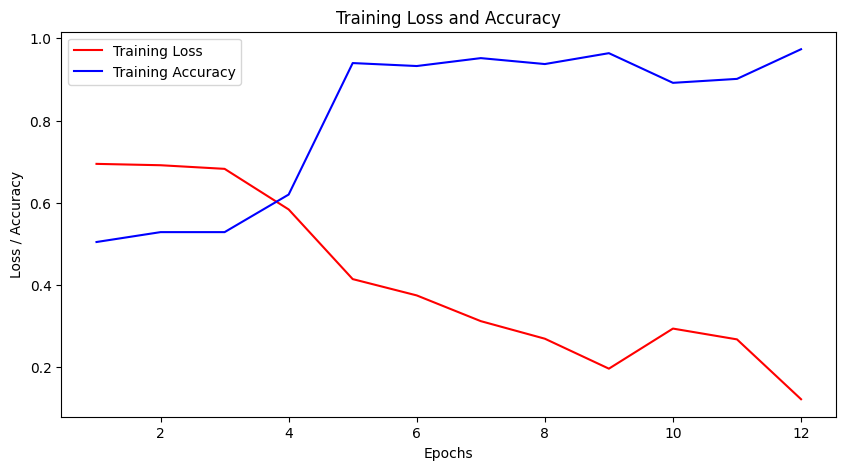

In [48]:
import matplotlib.pyplot as plt

# Access the training history
loss = history.history['loss']
accuracy = history.history['accuracy']

# Create a list of the epochs (assuming it starts from 1)
epochs = range(1, len(loss) + 1)

# Create a figure
plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy')
plt.legend()

# Show the plot
plt.show()

In [49]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 63, 63, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 61, 61, 64)        147520    
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 14, 14, 32)       

**Save model**

In [50]:
#Preserve the result of the trained model for further use
cnn.save("model.h5")
print("Model saved to disk")

Model saved to disk


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
#Load model
model = load_model('model.h5')

**Make prediction on the test dataset**

In [52]:
#Prediction
test_prediction = model.predict(x_test)

5/5 [==============================] - 0s 24ms/step


In [53]:
pred = []

for i in test_prediction:
  # print(i)
  if(i >= 0.5):
    pred.append(1)
  else:
    pred.append(0)

# pred

In [54]:
#Inverse binary label to original class labels

test = encodeTool.inverse_transform(pred)
test

array(['Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Uninfected', 'Parasite', 'Parasite',
       'Parasite', 'Parasite', 'Parasite', 'Parasite', 'Parasite',
       'Parasite', 'Parasite', 'Uninfected', 'Parasite', 'Parasite',
       'Parasite', 'Parasite', 'Parasite', 'Uninfected', 'Parasite',
       'Uninfected', 'Parasite', 'Parasite', 'Parasite', 'Parasite',
       'Parasite', 'Par

In [55]:
accuracy = model.evaluate(x_test,y_test)
print("Accuracy: ",accuracy)

5/5 [==============================] - 0s 18ms/step - loss: 0.2441 - accuracy: 0.9030
Accuracy:  [0.24413728713989258, 0.9029850959777832]


In [56]:
#print overall accuracy
from sklearn import metrics

print("Accuracy = ",metrics.accuracy_score(test_labels,test))

Accuracy =  0.9029850746268657


1/1 [==============================] - 0s 20ms/step


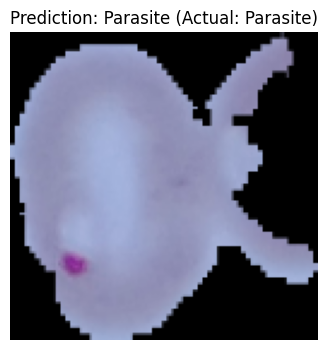

1/1 [==============================] - 0s 20ms/step


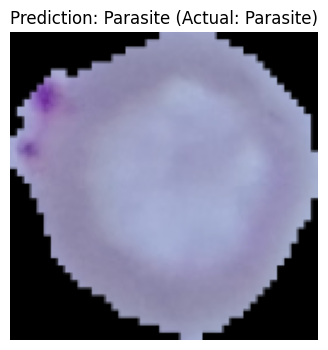

1/1 [==============================] - 0s 18ms/step


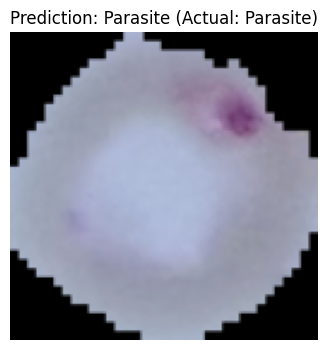

1/1 [==============================] - 0s 18ms/step


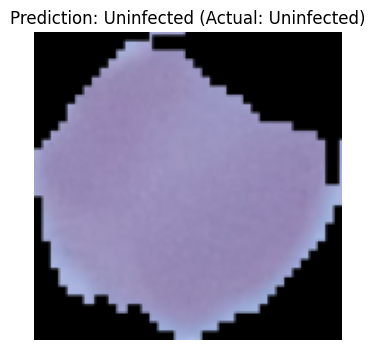

1/1 [==============================] - 0s 20ms/step


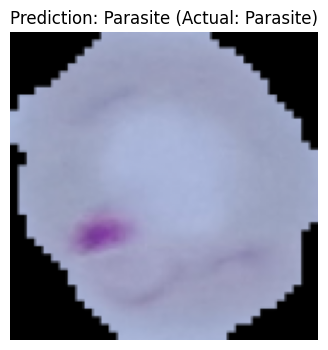

Model works well (5/5 correct predictions).


In [58]:
import random
import matplotlib.pyplot as plt

# Initialize a counter to keep track of correct predictions
correct_predictions = 0

# Test 5 random pictures
for _ in range(5):
    n = random.randint(0, x_test.shape[0] - 1)
    img = x_test[n]

    input_img = np.expand_dims(img, axis=0)
    img_prediction = model.predict(input_img)

    if img_prediction >= 0.5:
        img_prediction = 1
    else:
        img_prediction = 0
    img_prediction = encodeTool.inverse_transform([img_prediction])

    actual_label = test_labels[n]

    # Display the image, prediction, and actual label
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title("Prediction: {} (Actual: {})".format(img_prediction[0], actual_label))
    plt.axis('off')
    plt.show()

    if img_prediction == actual_label:
        correct_predictions += 1

# Check the accuracy
if correct_predictions == 5:
    print("Model works well (5/5 correct predictions).")
else:
    print("Model doesn't work well ({} correct predictions out of 5).".format(correct_predictions))
